Classifying flower images by fine-tuning an ensemble model composed of:

convnext_base.fb_in1k, efficientnet_b0, resnet18

from Timm models.

In [1]:
!uv pip install torch torchvision timm tfrecord opencv-python-headless matplotlib numpy seaborn tqdm polars --system

Using Python 3.11.13 environment at: /usr
Resolved 66 packages in 399ms
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
⠙ Preparing packages... (0/2)
   Building tfrecord==1.14.6
⠙ Preparing packages... (0/2)
   Building tfrecord==1.14.6
⠙ Preparing packages... (0/2)
   Building tfrecord==1.14.6
⠙ Preparing packages... (0/2)
   Building tfrecord==1.14.6
⠙ Preparing packages... (0/2)
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
   Building tfrecord==1.14.6
      Built tfrecord==1.14.6
Prepared 2 packages in 3

In [2]:
# Import Torch 
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

#Import file handling 
import cv2, tfrecord

# TorchVision imports 
import torchvision
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
import timm # pytorch image model library 
import os, numpy as np, random, polars as pl

from tqdm import tqdm


# For Cuda
device = "cuda" if torch.cuda.is_available() else "cpu"

# For TPU
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

In [3]:
# Transform the images
# - Adding in a bunch of different data augmentation to prevent overfitting on training data 
# - Using a mixture of random rotations/flips + blurring/cropping 

# These transforms make it more innacurate 
    # transforms.RandomRotation(degrees=15),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    # transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalizing based on imagenet pre-trained model normalization
    ]) 

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [4]:
FLOWER_NAMES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']  

# Defining data path 
dataSetPath = "/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512"
# using smaller datasets, when I want to test fast
# dataSetPath = "/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224"
# dataSetPath = "/kaggle/input/tpu-getting-started/tfrecords-jpeg-192x192"

def transform_tf_to_df(subset, sample_rate=0.01):
    tf_files, ids, classes, images = [], [], [], []

    for subdir, _, files in os.walk(dataSetPath):
        if subdir.endswith(subset):
            tf_files.extend(os.path.join(subdir, f) for f in files)

    for tf_file in tf_files:
        schema = {"id": "byte", "image": "byte"}
        if subset != "test":
            schema["class"] = "int"
        loader = tfrecord.tfrecord_loader(tf_file, None, schema)

        for r in loader:
            # Setting sampling rate, to test on a smaller dataset
            # if random.random() > sample_rate: 
            #     continue
            ids.append(r["id"].decode())
            classes.append(r["class"][0].item() if subset != "test" else None)
            img = cv2.cvtColor(cv2.imdecode(np.frombuffer(r["image"], np.uint8), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
            images.append(img)

    return pl.DataFrame({"id": ids, "class": classes, "img": pl.Series("img", images, dtype=pl.Object)})


class FlowersDataset(Dataset):
    def __init__(self, data: pl.DataFrame, transform=None) -> None:
        self.data = data
        self.transform = transform

    def __getitem__(self, idx):
        label = self.data["class"][idx]
        image_arr = self.data["img"][idx]
        image = Image.fromarray(image_arr)
        if self.transform:
            image = self.transform(image)
        y = np.zeros(len(FLOWER_NAMES), dtype=np.float32)
        y[label] = 1
        return image, y

    def __len__(self) -> int:
        return self.data.shape[0]

df_validation = transform_tf_to_df('val')
df_train = transform_tf_to_df('train')

train_data = FlowersDataset(df_train, transform=train_transform)
validation_data = FlowersDataset(df_validation, transform=test_transform)

BATCH_SIZE = 10
num_batches = len(train_data) // BATCH_SIZE
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders: {train_dataloader}")
print(f"Length of train DataLoader {len(train_dataloader)} with training data count {len(train_data)}")


DataLoaders: <torch.utils.data.dataloader.DataLoader object at 0x791ddc53dc90>
Length of train DataLoader 1276 with training data count 12753


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


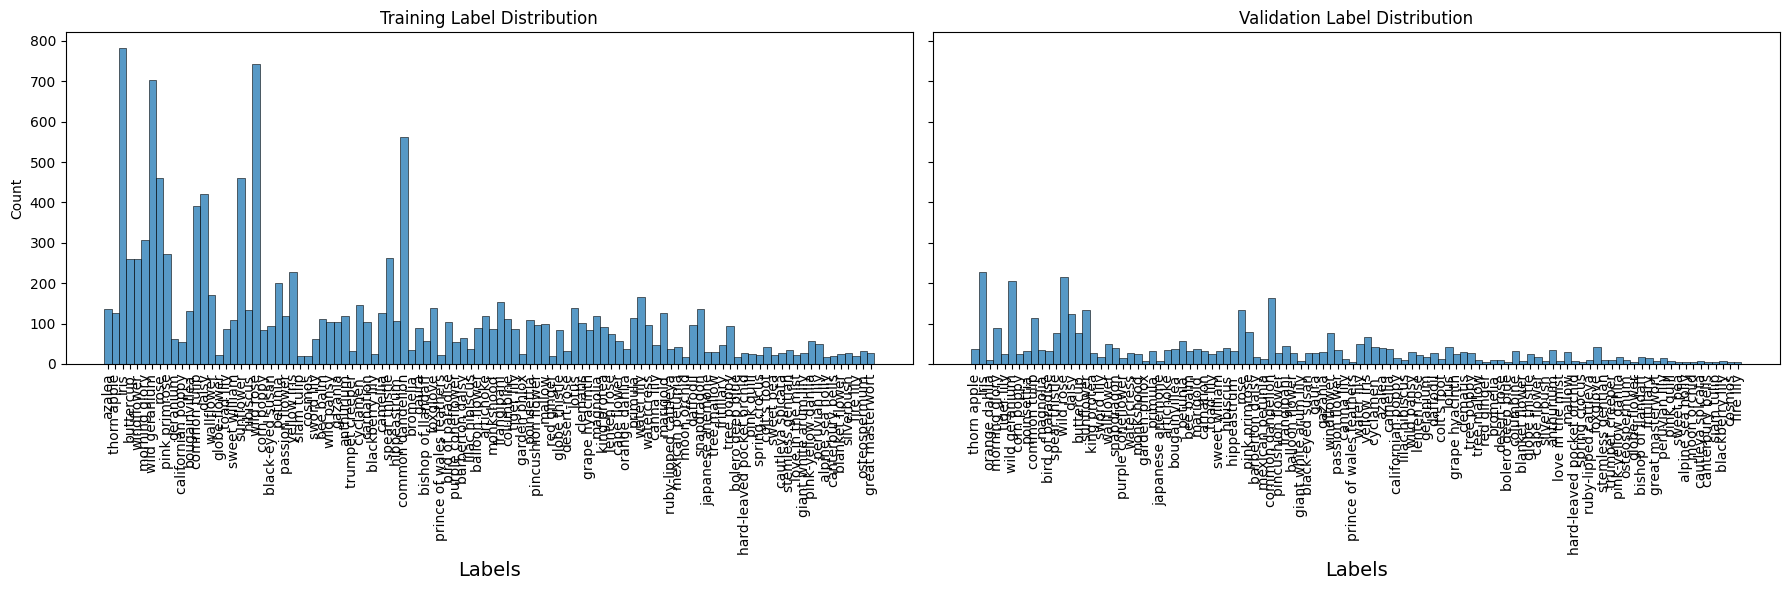

In [5]:
# Compare histograms of class frequencies from each datasets, to see distribution of data in data-sets
import seaborn as sns

train_image_distribution = [FLOWER_NAMES[label] for label in df_train['class']]
valid_image_distribution = [FLOWER_NAMES[label] for label in df_validation['class']]

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Plot the first histogram
sns.histplot(train_image_distribution, discrete=True, kde=False, ax=axes[0])
axes[0].set_title('Training Label Distribution')
axes[0].set_xlabel('Labels', fontsize=14)
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)
axes[0].xaxis.set_tick_params(labelsize=10)

# Plot the second histogram
sns.histplot(valid_image_distribution, discrete=True, kde=False, ax=axes[1])
axes[1].set_title('Validation Label Distribution')
axes[1].set_xlabel('Labels', fontsize=14)
axes[1].tick_params(axis='x', rotation=90)
axes[1].xaxis.set_tick_params(labelsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

In [6]:
# Dataset is unbalanced, so I'm going to add weights for underepresented classes in the loss-function, to prevent overfitting on the majority classes.


# I tried this experiment just training a singular model with weights and without weights, and noticed a significant drop in accuracy 

# Experiments done
#  - Epochs = 10 -> 83.38 % , lR = 0.01 (No weighted + No image transformations)
#  - Epochs = 10 -> 83.86 % , lR = 0.01 (No weighted + image transformations (with random rotation) )
#  - Epochs = 10 -> 85.37 % , lR = 0.01 (No weighted + image transformations (without random rotation) )
#  - Epochs = 10 -> 73.57 % , lR = 0.01 (Using weights for under-represented images + No image transformations )
#  - Epochs = 10 -> 80.33 % , lR = 0.001 (Using weights for under-represented images + image transformations )

total_samples = len(train_image_distribution)
num_classes = len(FLOWER_NAMES)

# class_counts = torch.zeros(len(FLOWER_NAMES), dtype=torch.float32)
# for label in df_train['class']:
#     class_counts[label] += 1

# class_weights = total_samples / (num_classes * class_counts)
# class_weights = class_weights.float().to(device)

# class_counts




In [7]:
# Setup training and validation steps

# I skip saving intermediate values to memory to leverage operation fusing for faster training.
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler._LRScheduler):

    model.train()
    train_loss, train_acc, total_samples = 0, 0, 0

    for X, y in dataloader:

        # Calculate predictions / losses of model
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        # Updating Model Weights
        optimizer.zero_grad()
        loss.backward()
        
        # Updating optimizer step
        optimizer.step()
        scheduler.step()

        train_acc += (y_pred.argmax(dim =1 ) == y.argmax(dim=1)).sum().item()
        total_samples += len(y)

    train_loss /= total_samples
    train_acc /= total_samples
    return train_loss , train_acc

# Tracking the accuracy of the model over time with respect to the validation dataset
def valid_step(model:torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module):

    model.eval()
    valid_loss, valid_acc, total_samples = 0, 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            valid_loss += loss_fn(y_pred, y).item()
            valid_acc  += (y_pred.argmax(dim =1 ) == y.argmax(dim =1)).sum().item()
            total_samples += len(y)
    valid_loss /= total_samples
    valid_acc /= total_samples
    return valid_loss, valid_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler._LRScheduler,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int= 5,
          best_model_path: str = "best_model.pt" ):
    results = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": [] }
    best_valid_acc = 0.0
    torch.save(model.state_dict(), best_model_path)
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model, dataloader = train_dataloader, loss_fn = loss_fn, optimizer = optimizer, scheduler = scheduler)
        valid_loss, valid_acc = valid_step(model = model, dataloader = valid_dataloader, loss_fn = loss_fn)

        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | valid_loss: {valid_loss:.4f} | valid_acc: {valid_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)

        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with validation accuracy: {best_valid_acc:.4f}")

    return results 
        

In [8]:
# Train Models individually
from timeit import default_timer as timer
output_shape = len(FLOWER_NAMES)

# Can't use torch.compile on Tesla P100 due to cuda compatability issues with triton

"""
Note that Kaggle timed out after exceeding the 12 hour time limit, so I'm uploading the intermediate model to resume training

model_0 ended with logs
38512.1s	87	Epoch: 11 | train_loss: 0.0000 | train_acc: 1.0000 | valid_loss: 0.0161 | valid_acc: 0.9701
42005.2s	88	Epoch: 12 | train_loss: 0.0000 | train_acc: 1.0000 | valid_loss: 0.0161 | valid_acc: 0.9701

model_1 finished after epoch = 4

"""
model_0 = timm.create_model('convnext_base', pretrained=True, num_classes=output_shape)
model_1 = timm.create_model("efficientnet_b0", pretrained=True, num_classes=output_shape)
model_2 = timm.create_model("resnet18", pretrained=True, num_classes=output_shape)
# num_epochs = 12

model_results = []
for idx, model in enumerate([model_0 , model_1, model_2]):
    model.to(device)
    start_time = timer()
    
    
    if idx  == 0 :
        model.load_state_dict(torch.load("/kaggle/input/checkpoint_models_petals_to_metal/pytorch/default/1/best_model_0.pt"))
        continue
    elif idx == 1: 
        model.load_state_dict(torch.load("/kaggle/input/checkpoint_models_petals_to_metal/pytorch/default/1/best_model_1.pt"))
        num_epochs = 8
    else: 
        num_epochs = 12

    loss_fn = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.AdamW(params = model.parameters(), lr=0.0001, weight_decay = 1e-2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs * num_batches)
    
    model_result = train(model=model, 
                            train_dataloader=train_dataloader,
                            valid_dataloader= validation_dataloader,
                            optimizer=optimizer,
                            scheduler = scheduler,
                            loss_fn=loss_fn, 
                            epochs=num_epochs,
                            best_model_path=f"best_model_{idx}.pt")
    model_results.append(model_result)
    model.load_state_dict(torch.load(f"best_model_{idx}.pt"))
    torch.cuda.empty_cache()
    end_time = timer()
    print(f"Total training time: {end_time-start_time:.3f} seconds")
    
# Experiments done using image size of 214x214
#  - Epochs = 10 -> 83.38 % , lR = 0.01 (No weighted + No image transformations)
#  - Epochs = 10 -> 83.86 % , lR = 0.01 (No weighted + image transformations (with random rotation) )
#  - Epochs = 10 -> 85.37 % , lR = 0.01 (No weighted + image transformations (without random rotation) )
#  - Epochs = 10 -> 73.57 % , lR = 0.01 (Using weights for under-represented images + No image transformations )
#  - Epochs = 10 -> 80.33 % , lR = 0.001 (Using weights for under-represented images + image transformations )
# Epoch: 10 | train_loss: 0.0022 | train_acc: 0.9948 | valid_loss: 0.0224 | valid_acc: 0.9114 for xception on adamw

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

 12%|█▎        | 1/8 [04:16<29:55, 256.48s/it]

Epoch: 1 | train_loss: 0.0175 | train_acc: 0.9552 | valid_loss: 0.0322 | valid_acc: 0.9270
Saved best model with validation accuracy: 0.9270


 25%|██▌       | 2/8 [08:31<25:33, 255.64s/it]

Epoch: 2 | train_loss: 0.0126 | train_acc: 0.9675 | valid_loss: 0.0325 | valid_acc: 0.9281
Saved best model with validation accuracy: 0.9281


 38%|███▊      | 3/8 [12:46<21:17, 255.45s/it]

Epoch: 3 | train_loss: 0.0083 | train_acc: 0.9791 | valid_loss: 0.0330 | valid_acc: 0.9251


 50%|█████     | 4/8 [17:01<17:01, 255.37s/it]

Epoch: 4 | train_loss: 0.0052 | train_acc: 0.9871 | valid_loss: 0.0287 | valid_acc: 0.9364
Saved best model with validation accuracy: 0.9364


 62%|██████▎   | 5/8 [21:16<12:45, 255.21s/it]

Epoch: 5 | train_loss: 0.0035 | train_acc: 0.9930 | valid_loss: 0.0301 | valid_acc: 0.9362


 75%|███████▌  | 6/8 [25:31<08:30, 255.14s/it]

Epoch: 6 | train_loss: 0.0025 | train_acc: 0.9958 | valid_loss: 0.0302 | valid_acc: 0.9367
Saved best model with validation accuracy: 0.9367


 88%|████████▊ | 7/8 [29:46<04:15, 255.10s/it]

Epoch: 7 | train_loss: 0.0019 | train_acc: 0.9968 | valid_loss: 0.0289 | valid_acc: 0.9402
Saved best model with validation accuracy: 0.9402


100%|██████████| 8/8 [34:01<00:00, 255.25s/it]

Epoch: 8 | train_loss: 0.0018 | train_acc: 0.9969 | valid_loss: 0.0299 | valid_acc: 0.9388


Total training time: 2042.507 seconds


  8%|▊         | 1/12 [02:38<29:03, 158.51s/it]

Epoch: 1 | train_loss: 0.3509 | train_acc: 0.2281 | valid_loss: 0.2602 | valid_acc: 0.3839
Saved best model with validation accuracy: 0.3839


 17%|█▋        | 2/12 [05:17<26:25, 158.50s/it]

Epoch: 2 | train_loss: 0.2326 | train_acc: 0.4518 | valid_loss: 0.1638 | valid_acc: 0.6210
Saved best model with validation accuracy: 0.6210


 25%|██▌       | 3/12 [07:55<23:48, 158.72s/it]

Epoch: 3 | train_loss: 0.1642 | train_acc: 0.6093 | valid_loss: 0.1183 | valid_acc: 0.7077
Saved best model with validation accuracy: 0.7077


 33%|███▎      | 4/12 [10:34<21:09, 158.71s/it]

Epoch: 4 | train_loss: 0.1265 | train_acc: 0.6944 | valid_loss: 0.0907 | valid_acc: 0.7680
Saved best model with validation accuracy: 0.7680


 42%|████▏     | 5/12 [13:13<18:30, 158.64s/it]

Epoch: 5 | train_loss: 0.1057 | train_acc: 0.7458 | valid_loss: 0.0777 | valid_acc: 0.7961
Saved best model with validation accuracy: 0.7961


 50%|█████     | 6/12 [15:51<15:51, 158.58s/it]

Epoch: 6 | train_loss: 0.0907 | train_acc: 0.7811 | valid_loss: 0.0682 | valid_acc: 0.8225
Saved best model with validation accuracy: 0.8225


 58%|█████▊    | 7/12 [18:30<13:13, 158.63s/it]

Epoch: 7 | train_loss: 0.0810 | train_acc: 0.8070 | valid_loss: 0.0629 | valid_acc: 0.8370
Saved best model with validation accuracy: 0.8370


 67%|██████▋   | 8/12 [21:08<10:34, 158.52s/it]

Epoch: 8 | train_loss: 0.0739 | train_acc: 0.8248 | valid_loss: 0.0594 | valid_acc: 0.8446
Saved best model with validation accuracy: 0.8446


 75%|███████▌  | 9/12 [23:47<07:55, 158.55s/it]

Epoch: 9 | train_loss: 0.0695 | train_acc: 0.8352 | valid_loss: 0.0569 | valid_acc: 0.8586
Saved best model with validation accuracy: 0.8586


 83%|████████▎ | 10/12 [26:25<05:16, 158.45s/it]

Epoch: 10 | train_loss: 0.0662 | train_acc: 0.8448 | valid_loss: 0.0563 | valid_acc: 0.8534


 92%|█████████▏| 11/12 [29:03<02:38, 158.42s/it]

Epoch: 11 | train_loss: 0.0676 | train_acc: 0.8380 | valid_loss: 0.0557 | valid_acc: 0.8605
Saved best model with validation accuracy: 0.8605


100%|██████████| 12/12 [31:41<00:00, 158.47s/it]

Epoch: 12 | train_loss: 0.0650 | train_acc: 0.8439 | valid_loss: 0.0560 | valid_acc: 0.8578
Total training time: 1901.842 seconds


In [9]:
# Find the optmial weights for outputs of each model, when combining for ensemble.
# Uses vectorized processing for speed
from sklearn.metrics import  f1_score
@torch.no_grad()
def ensemble_grid_search_chunked(models, dataloader, steps=100, chunk_size=2048):
    for m in models: m.eval()

    # Run models once over the whole validation set, collect logits
    outs = [[] for _ in models]; ys = []
    for X, y in dataloader:
        X = X.to(device)
        ys.append(y.argmax(1))
        for i, m in enumerate(models):
            outs[i].append(m(X))

    logits = [torch.cat(o, 0) for o in outs]       # list of [N, C]
    stack = torch.stack(logits, 0)                 # [3, N, C]
    y = torch.cat(ys).cpu().numpy()
    C = stack.shape[-1]

    g = torch.linspace(0, 1, steps, device=device)
    A, B = torch.meshgrid(g, g, indexing='ij')
    G = 1 - A - B
    mask = (G >= 0) # Filter cases where model is excluded

    # Flatten masked coordinates -> length K
    a_all = A[mask]                      
    b_all = B[mask]                              
    g_all = G[mask]                               
    K = a_all.shape[0]

    # Sweep W in chunks
    best_f1 = -1.0
    best_w  = None

    # Pre-allocate CPU array once for sklearn calls if helpful
    # (we still compute per-chunk preds to keep memory bounded)
    for start in range(0, K, chunk_size):
        end = min(start + chunk_size, K)

        # Build W_chunk: [k, 3] on device
        W_chunk = torch.stack([a_all[start:end], b_all[start:end], g_all[start:end]], dim=1)  # [k, 3]

        # Batched ensemble for this chunk: [k, N, C]
        # einsum: W_chunk[k, c] * stack[c, n, d] -> ens[k, n, d]
        ens_chunk = torch.einsum('kc,cnd->knd', W_chunk, stack)

        # Argmax over classes -> predictions: [k, N]
        preds_chunk = ens_chunk.argmax(-1).cpu().numpy()

        # Score each row in this chunk and track the global best
        # (vectorized sklearn F1 doesn't exist; loop over rows)
        for i in range(preds_chunk.shape[0]):
            f1 = f1_score(y, preds_chunk[i], labels=range(C), average='macro', zero_division=0)
            if f1 > best_f1:
                best_f1 = float(f1)
                ai = float(a_all[start + i].item())
                bi = float(b_all[start + i].item())
                gi = float(g_all[start + i].item())
                best_w = (ai, bi, gi)

        # free up GPU memory for this chunk early
        del W_chunk, ens_chunk
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
    return best_w, best_f1
    
start_time = timer()
best_weight, best_f1 = ensemble_grid_search_chunked([model_0, model_1, model_2], validation_dataloader)
print(f"Total search time: {start_time-end_time:.3f} seconds")
print("Best ensemble configuration for Ensemble:")
print(f"  Weights (α, β, γ): {best_weight}")
print(f"  Best Macro F1: {best_f1:.4f}")


Total search time: 0.334 seconds
Best ensemble configuration for Ensemble:
  Weights (α, β, γ): (0.38383838534355164, 0.5858585834503174, 0.030303001403808594)
  Best Macro F1: 0.9704


In [10]:
"""
Note that Kaggle timed out after exceeding the 12 hour time limit.

So I lost the inetemediate training results for plotting

"""

# Plot losses over epochs for training data and validation data

# import matplotlib.pyplot as plt

# plt.figure(figsize=(15, 7))
# epochs_range = range(num_epochs)
# colors = ['blue', 'green', 'red']

# for i, result in enumerate(model_results):
#     plt.plot(epochs_range, result['train_acc'], label=f'Model {i} Train Accuracy', color=colors[i], linestyle='-')
#     plt.plot(epochs_range, result['valid_acc'], label=f'Model {i} Validation Accuracy', color=colors[i], linestyle='--')

# plt.title('Training and Validation Accuracy for All Models')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()


'\nNote that Kaggle timed out after exceeding the 12 hour time limit.\n\nSo I lost the inetemediate training results for plotting\n\n'

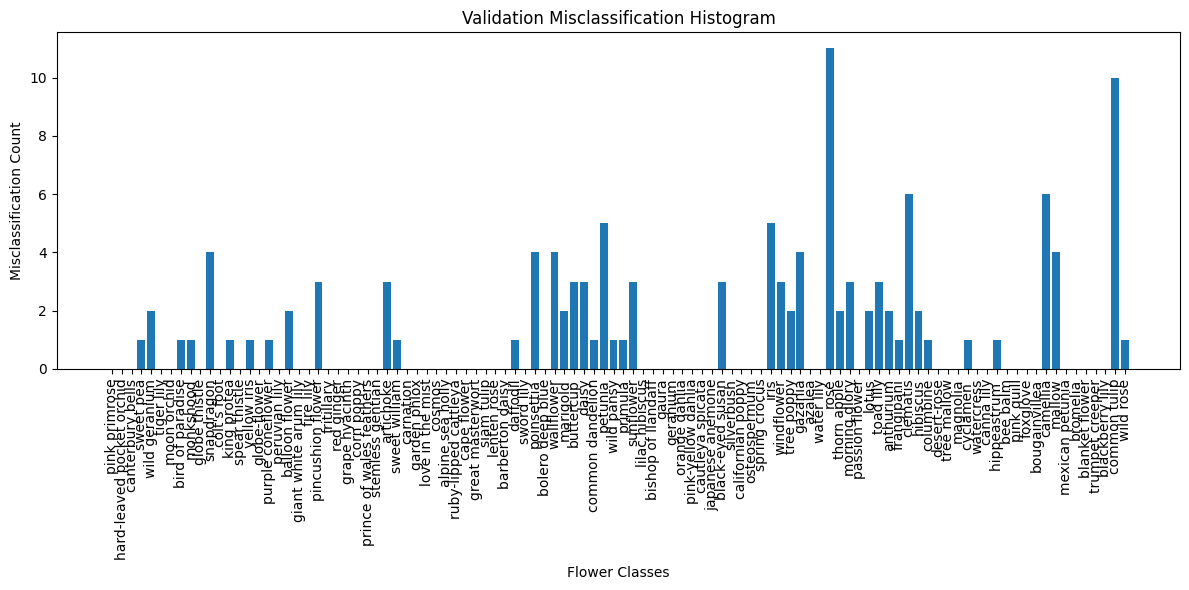

In [11]:
# Calculate make a confusion histogram for validation data
# Ensure models are in evaluation mode
model_0.eval(), model_1.eval(), model_2.eval()

# Unpack best ensemble configuration (alpha, beta, gamma)
alpha, beta, gamma = best_weight

# Initialize an array to hold misclassification counts per true label
misclass_counts = np.zeros(len(FLOWER_NAMES), dtype=int)

# Loop over the validation set and accumulate misclassification counts
with torch.inference_mode():
    for X, y in validation_dataloader:
        X, y = X.to(device), y.to(device)
        # Compute ensemble predictions
        outputs = alpha * model_0(X) + beta * model_1(X) + gamma * model_2(X)
        y_pred = outputs.argmax(dim=1)
        y_true = y.argmax(dim=1)
        
        # For each sample, if misclassified, increment the counter for its true label
        for true, pred in zip(y_true.cpu().numpy(), y_pred.cpu().numpy()):
            if true != pred:
                misclass_counts[true] += 1

# Plot the misclassification histogram
plt.figure(figsize=(12, 6))
plt.bar(range(len(misclass_counts)), misclass_counts, tick_label=FLOWER_NAMES)
plt.xticks(rotation=90)
plt.title("Validation Misclassification Histogram")
plt.xlabel("Flower Classes")
plt.ylabel("Misclassification Count")
plt.tight_layout()
plt.show()

In [12]:
def get_test_predictions(model_0, model_1, model_2, test_dataloader, best_weight):
    alpha, beta, gamma = best_weight
    model_0.eval(); model_1.eval(); model_2.eval()
    # 
    all_preds = []
    with torch.inference_mode():
        for X, _ in test_dataloader:
            X = X.to(device)
            # Compute ensemble outputs with best_weights
            outputs = alpha * model_0(X) + beta * model_1(X) + gamma * model_2(X)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu())
    
    # Concatenate predictions into one list
    all_preds = torch.cat(all_preds, dim=0).tolist()
    
    # Create submission Polars DataFrame using the 'id' column from df_test 
    submission_df = pl.DataFrame({'id': df_test['id'], 'label': all_preds})
    return submission_df

df_test = transform_tf_to_df('test')
test_data = FlowersDataset(df_test, transform=test_transform)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
print(f"Length of test DataLoader {len(test_dataloader)} with number of test data {len(test_data)}")

submission_df = get_test_predictions(model_0, model_1, model_2, test_dataloader, best_weight)
print(submission_df.head())

# Save CSV using Polars
submission_df.write_csv('/kaggle/working/submission.csv')
print("✅ submission.csv successfully created and saved!")

Length of test DataLoader 739 with number of test data 7382
shape: (5, 2)
┌───────────┬───────┐
│ id        ┆ label │
│ ---       ┆ ---   │
│ str       ┆ i64   │
╞═══════════╪═══════╡
│ 0b9afbdf2 ┆ 102   │
│ 8097bc805 ┆ 76    │
│ 2f9bf2b8a ┆ 84    │
│ c245c24bd ┆ 59    │
│ 0f33f1ca9 ┆ 103   │
└───────────┴───────┘
✅ submission.csv successfully created and saved!
